<a href="https://colab.research.google.com/github/Dipanjan199/GIS-Major-Project/blob/main/RF_Training_Final_Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas rasterio shapely fiona pyproj

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 31.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import rasterio
from rasterio.enums import Resampling
from rasterio.features import rasterize
import geopandas as gpd
import pandas as pd
import numpy as np

def resample_to_match(source_path, reference_path):
    with rasterio.open(reference_path) as ref:
        ref_shape = (ref.height, ref.width)
    with rasterio.open(source_path) as src:
        data = src.read(
            out_shape=(1, ref_shape[0], ref_shape[1]),
            resampling=Resampling.nearest
        )[0]
    return data

def rasterize_wse(gdf, reference_raster_path, attribute="wse"):
    with rasterio.open(reference_raster_path) as ref:
        transform = ref.transform
        shape = (ref.height, ref.width)
        crs = ref.crs

    if gdf.crs != crs:
        gdf = gdf.to_crs(crs)

    if gdf.crs.is_geographic:
        gdf = gdf.to_crs(gdf.estimate_utm_crs())

    gdf['geometry'] = gdf.geometry.centroid
    gdf = gdf.to_crs(crs)

    shapes = [(geom, value) for geom, value in zip(gdf.geometry, gdf[attribute])]
    wse_raster = rasterize(
        shapes=shapes,
        out_shape=shape,
        transform=transform,
        fill=np.nan,
        dtype='float32'
    )
    return wse_raster

# --- Paths ---
base_path = "https://drive.google.com/drive/folders/1nzZz4rsnEh1OZ1IGZih5A2YysHoatbB6?usp=drive_link"
year = 1990
ref_path = os.path.join(base_path, f"recovery_index_{year}.tif")

pop_path = "https://drive.google.com/file/d/1WbwH9TuQD59C_uxgVRw6Lg64ISqJj-bd/view?usp=drive_link"
distance_path = os.path.join(base_path, "normalized_distance_to_water_1990.tif")
forest_loss_path = None  # No forest loss data for 1990

# SWOT
#swot_path = "/content/drive/MyDrive/Recovery/SWOT/SWOT_Brahmaputra.shp"
#swot_gdf = gpd.read_file(swot_path)
#swot_gdf = swot_gdf[swot_gdf['river_name'].str.lower() == 'brahmaputra']

print(f"\n🔍 Extracting features for {year}...")

if not os.path.exists(ref_path):
    raise FileNotFoundError(f"Recovery raster not found: {ref_path}")

try:
    features = {
        'year': np.full(resample_to_match(ref_path, ref_path).shape, year),
        'vegetation': resample_to_match(os.path.join(base_path, f"veg_reclass_{year}.tif"), ref_path),
        'ndvi': resample_to_match(os.path.join(base_path, f"ndvi_{year}.tif"), ref_path),
        'dry_exposure': resample_to_match(os.path.join(base_path, f"dry_exposure_{year}.tif"), ref_path),
        'z_score': resample_to_match(os.path.join(base_path, f"z_score_{year}.tif"), ref_path),
        'slope': resample_to_match(os.path.join(base_path, f"slope_{year}.tif"), ref_path),
        'population_density': resample_to_match(pop_path, ref_path),
        'distance_to_water': resample_to_match(distance_path, ref_path) if os.path.exists(distance_path)
                              else np.full(resample_to_match(ref_path, ref_path).shape, np.nan),
        'forest_loss': np.full(resample_to_match(ref_path, ref_path).shape, np.nan),  # Placeholder
        'swot_wse': np.full(resample_to_match(ref_path, ref_path).shape, np.nan)  # Not used in 1990
    }

    with rasterio.open(ref_path) as ref_src:
        target = ref_src.read(1)
        target[target == ref_src.nodata] = np.nan
        features['recovery_index'] = target

        # Add coordinates
        rows, cols = np.meshgrid(np.arange(ref_src.height), np.arange(ref_src.width), indexing='ij')
        xs, ys = rasterio.transform.xy(ref_src.transform, rows, cols)
        features['x'] = np.array(xs).flatten()
        features['y'] = np.array(ys).flatten()
        crs = ref_src.crs

    df = pd.DataFrame({k: v.flatten() for k, v in features.items()})

    print(f"📏 Total samples: {len(df)}")
    missing = df.isna().sum()
    print(f"❗ Missing values per column:\n{missing[missing > 0]}")

    df = df.dropna(subset=['recovery_index'])  # Ensure valid training data

    print(f"✅ Valid training samples: {len(df)}")

    # Save CSV & GeoPackage
    csv_path = os.path.join(base_path, f"recovery_training_1990.csv")
    df.to_csv(csv_path, index=False)

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['x'], df['y']),
        crs=crs
    )
    gpkg_path = os.path.join(base_path, f"recovery_training_1990.gpkg")
    gdf.to_file(gpkg_path, driver="GPKG")

    print(f"💾 CSV saved: {csv_path}")
    print(f"🌍 GPKG saved: {gpkg_path}")

except Exception as e:
    print(f"❌ Error: {e}")



ModuleNotFoundError: No module named 'rasterio'

✅ Model will be trained on 84,131 samples for year 1990
✅ GeoTIFF saved to: /content/RESULT/output_1990.tif


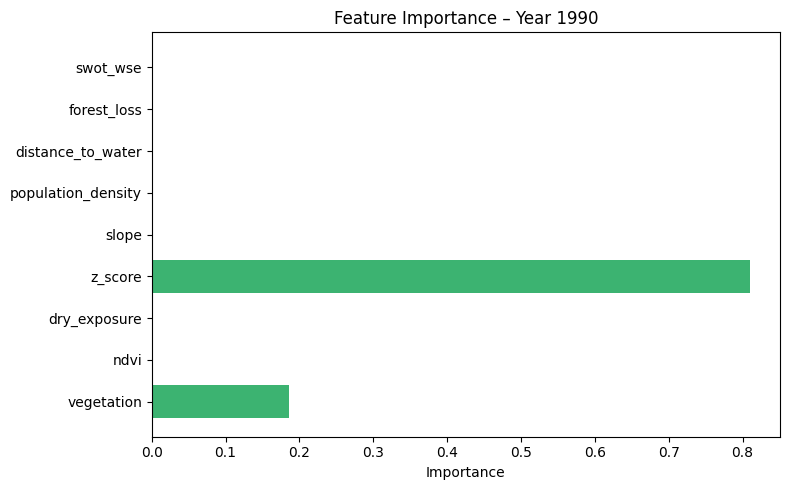

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import rasterio
from rasterio.transform import from_origin
import numpy as np

# -------------------------------
# 🔹 Step 1: Load GPKG for 1990
# -------------------------------
gpkg_path = "/content/Output_1/recovery_training_1990.gpkg"
gdf_1990 = gpd.read_file(gpkg_path)

# Standardize column names
gdf_1990.columns = [col.strip().lower() for col in gdf_1990.columns]
if 'veg' in gdf_1990.columns:
    gdf_1990.rename(columns={'veg': 'vegetation'}, inplace=True)

# Feature and target columns
features = [
    'vegetation', 'ndvi', 'dry_exposure', 'z_score', 'slope',
    'population_density', 'distance_to_water', 'forest_loss', 'swot_wse'
]
target = 'recovery_index'

# Drop rows with missing target only
gdf_1990 = gdf_1990.dropna(subset=[target])
X = gdf_1990[features]
y = gdf_1990[target]

print(f"✅ Model will be trained on {len(gdf_1990):,} samples for year 1990")

# -------------------------------
# 🔹 Step 2: Train Random Forest
# -------------------------------
model_1990 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_1990.fit(X, y)

# -------------------------------
# 🔹 Step 3: Predict Recovery Index
# -------------------------------
gdf_1990['predicted_recovery'] = model_1990.predict(X)

# -------------------------------
# 🔹 Step 4: Rasterize to GeoTIFF
# -------------------------------
# Define raster parameters
resolution = 0.00030  # degree grid cell (adjust as needed)
bounds = gdf_1990.total_bounds  # [minx, miny, maxx, maxy]
width = int((bounds[2] - bounds[0]) / resolution)
height = int((bounds[3] - bounds[1]) / resolution)
transform = from_origin(bounds[0], bounds[3], resolution, resolution)

# Create empty raster
raster = np.full((height, width), np.nan, dtype=np.float32)

# Map points to raster grid
for _, row in gdf_1990.iterrows():
    x, y = row.geometry.x, row.geometry.y
    col = int((x - bounds[0]) / resolution)
    row_idx = int((bounds[3] - y) / resolution)
    if 0 <= row_idx < height and 0 <= col < width:
        raster[row_idx, col] = row['predicted_recovery']

# Save GeoTIFF
tiff_path = "/content/RESULT/output_1990.tif"
with rasterio.open(
    tiff_path, "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs=gdf_1990.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)

print(f"✅ GeoTIFF saved to: {tiff_path}")

# -------------------------------
# 🔹 Step 5: Plot Feature Importance
# -------------------------------
importances = model_1990.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(features, importances, color='mediumseagreen')
plt.title('Feature Importance – Year 1990')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
import os
import rasterio
from rasterio.enums import Resampling
import geopandas as gpd
import pandas as pd
import numpy as np

def resample_to_match(source_path, reference_path):
    with rasterio.open(reference_path) as ref:
        ref_shape = (ref.height, ref.width)
    with rasterio.open(source_path) as src:
        data = src.read(
            out_shape=(1, ref_shape[0], ref_shape[1]),
            resampling=Resampling.nearest
        )[0]
    return data

# --- Paths ---
base_path = "/content/Output_1"
year = 2000
ref_path = os.path.join(base_path, f"recovery_index_{year}.tif")

pop_path = "/content/GHSL_Population_2000.tif"
distance_path = os.path.join(base_path, "normalized_distance_to_water_2000.tif")
forest_loss_path = os.path.join(base_path, "forest_loss_2000.tif")

print(f"\n🔍 Extracting features for {year}...")

try:
    features = {
        'year': np.full(resample_to_match(ref_path, ref_path).shape, year),
        'vegetation': resample_to_match(os.path.join(base_path, f"veg_reclass_{year}.tif"), ref_path),
        'ndvi': resample_to_match(os.path.join(base_path, f"ndvi_{year}.tif"), ref_path),
        'dry_exposure': resample_to_match(os.path.join(base_path, f"dry_exposure_{year}.tif"), ref_path),
        'z_score': resample_to_match(os.path.join(base_path, f"z_score_{year}.tif"), ref_path),
        'slope': resample_to_match(os.path.join(base_path, f"slope_{year}.tif"), ref_path),
        'population_density': resample_to_match(pop_path, ref_path),
        'distance_to_water': resample_to_match(distance_path, ref_path),
        'forest_loss': resample_to_match(forest_loss_path, ref_path),
        'swot_wse': np.full(resample_to_match(ref_path, ref_path).shape, np.nan)  # No SWOT data for 2000
    }

    with rasterio.open(ref_path) as ref_src:
        target = ref_src.read(1)
        target[target == ref_src.nodata] = np.nan
        features['recovery_index'] = target

        rows, cols = np.meshgrid(np.arange(ref_src.height), np.arange(ref_src.width), indexing='ij')
        xs, ys = rasterio.transform.xy(ref_src.transform, rows, cols)
        features['x'] = np.array(xs).flatten()
        features['y'] = np.array(ys).flatten()
        crs = ref_src.crs

    df = pd.DataFrame({k: v.flatten() for k, v in features.items()})
    print(f"📏 Total samples: {len(df)}")
    print(f"❗ Missing values per column:\n{df.isna().sum()[df.isna().sum() > 0]}")

    df = df.dropna(subset=['recovery_index'])
    print(f"✅ Valid training samples: {len(df)}")

    csv_path = os.path.join(base_path, f"recovery_training_{year}.csv")
    gpkg_path = os.path.join(base_path, f"recovery_training_{year}.gpkg")

    df.to_csv(csv_path, index=False)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs=crs)
    gdf.to_file(gpkg_path, driver="GPKG")

    print(f"💾 CSV saved: {csv_path}")
    print(f"🌍 GPKG saved: {gpkg_path}")

except Exception as e:
    print(f"❌ Error: {e}")



🔍 Extracting features for 2000...
📏 Total samples: 819312
❗ Missing values per column:
vegetation            735181
ndvi                  704990
dry_exposure          704478
population_density    689130
swot_wse              819312
recovery_index        735181
dtype: int64
✅ Valid training samples: 84131
💾 CSV saved: /content/Output_1/recovery_training_2000.csv
🌍 GPKG saved: /content/Output_1/recovery_training_2000.gpkg


✅ Model will be trained on 84,131 samples for year 2000
✅ GeoTIFF saved to: /content/RESULT/output_2000.tif


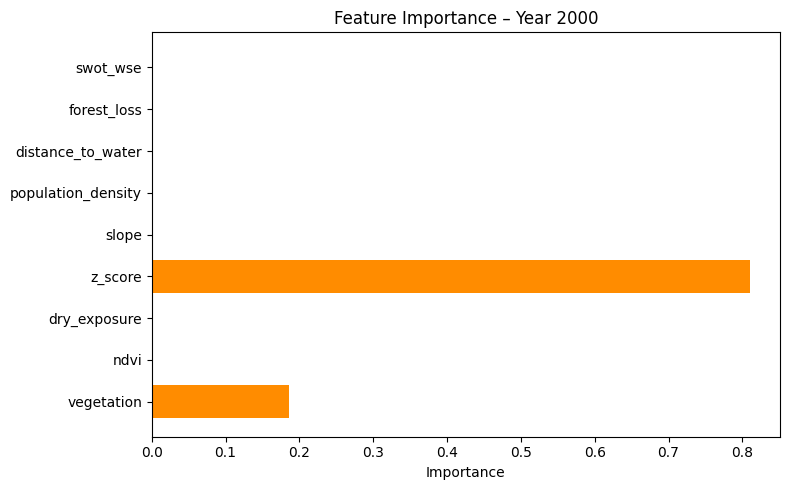

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import rasterio
from rasterio.transform import from_origin
import numpy as np

# -------------------------------
# 🔹 Step 1: Load GPKG for 2024
# -------------------------------
gpkg_path = "/content/Output_1/recovery_training_2000.gpkg"
gdf_2000 = gpd.read_file(gpkg_path)

# Standardize column names
gdf_2000.columns = [col.strip().lower() for col in gdf_2000.columns]
if 'veg' in gdf_2000.columns:
    gdf_2000.rename(columns={'veg': 'vegetation'}, inplace=True)

# Feature and target columns
features = [
    'vegetation', 'ndvi', 'dry_exposure', 'z_score', 'slope',
    'population_density', 'distance_to_water', 'forest_loss', 'swot_wse'
]
target = 'recovery_index'

# Drop rows with missing target only
gdf_2000 = gdf_2000.dropna(subset=[target])
X = gdf_2000[features]
y = gdf_2000[target]

print(f"✅ Model will be trained on {len(gdf_2000):,} samples for year 2000")

# -------------------------------
# 🔹 Step 2: Train Random Forest
# -------------------------------
model_2000 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_2000.fit(X, y)

# -------------------------------
# 🔹 Step 3: Predict Recovery Index
# -------------------------------
gdf_2000['predicted_recovery'] = model_2000.predict(X)

# -------------------------------
# 🔹 Step 4: Rasterize to GeoTIFF
# -------------------------------
resolution = 0.0003  # degree grid cell
bounds = gdf_2000.total_bounds  # [minx, miny, maxx, maxy]
width = int((bounds[2] - bounds[0]) / resolution)
height = int((bounds[3] - bounds[1]) / resolution)
transform = from_origin(bounds[0], bounds[3], resolution, resolution)

# Create empty raster
raster = np.full((height, width), np.nan, dtype=np.float32)

# Map points to raster grid
for _, row in gdf_2000.iterrows():
    x, y = row.geometry.x, row.geometry.y
    col = int((x - bounds[0]) / resolution)
    row_idx = int((bounds[3] - y) / resolution)
    if 0 <= row_idx < height and 0 <= col < width:
        raster[row_idx, col] = row['predicted_recovery']

# Save GeoTIFF
tiff_path = "/content/RESULT/output_2000.tif"
with rasterio.open(
    tiff_path, "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs=gdf_2000.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)

print(f"✅ GeoTIFF saved to: {tiff_path}")

# -------------------------------
# 🔹 Step 5: Plot Feature Importance
# -------------------------------
importances = model_2000.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(features, importances, color='darkorange')
plt.title('Feature Importance – Year 2000')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
import os
import rasterio
from rasterio.enums import Resampling
import geopandas as gpd
import pandas as pd
import numpy as np

def resample_to_match(source_path, reference_path):
    with rasterio.open(reference_path) as ref:
        ref_shape = (ref.height, ref.width)
    with rasterio.open(source_path) as src:
        data = src.read(
            out_shape=(1, ref_shape[0], ref_shape[1]),
            resampling=Resampling.nearest
        )[0]
    return data

# --- Paths ---
base_path = "/content/Output_1"
year = 2010
ref_path = os.path.join(base_path, f"recovery_index_{year}.tif")

pop_path = "/content/GHSL_Population_2000.tif"
distance_path = os.path.join(base_path, "normalized_distance_to_water_2010.tif")
forest_loss_path = os.path.join(base_path, "forest_loss_2010.tif")

print(f"\n🔍 Extracting features for {year}...")

try:
    features = {
        'year': np.full(resample_to_match(ref_path, ref_path).shape, year),
        'vegetation': resample_to_match(os.path.join(base_path, f"veg_reclass_{year}.tif"), ref_path),
        'ndvi': resample_to_match(os.path.join(base_path, f"ndvi_{year}.tif"), ref_path),
        'dry_exposure': resample_to_match(os.path.join(base_path, f"dry_exposure_{year}.tif"), ref_path),
        'z_score': resample_to_match(os.path.join(base_path, f"z_score_{year}.tif"), ref_path),
        'slope': resample_to_match(os.path.join(base_path, f"slope_{year}.tif"), ref_path),
        'population_density': resample_to_match(pop_path, ref_path),
        'distance_to_water': resample_to_match(distance_path, ref_path),
        'forest_loss': resample_to_match(forest_loss_path, ref_path),
        'swot_wse': np.full(resample_to_match(ref_path, ref_path).shape, np.nan)  # No SWOT data for 2010
    }

    with rasterio.open(ref_path) as ref_src:
        target = ref_src.read(1)
        target[target == ref_src.nodata] = np.nan
        features['recovery_index'] = target

        rows, cols = np.meshgrid(np.arange(ref_src.height), np.arange(ref_src.width), indexing='ij')
        xs, ys = rasterio.transform.xy(ref_src.transform, rows, cols)
        features['x'] = np.array(xs).flatten()
        features['y'] = np.array(ys).flatten()
        crs = ref_src.crs

    df = pd.DataFrame({k: v.flatten() for k, v in features.items()})
    print(f"📏 Total samples: {len(df)}")
    print(f"❗ Missing values per column:\n{df.isna().sum()[df.isna().sum() > 0]}")

    df = df.dropna(subset=['recovery_index'])
    print(f"✅ Valid training samples: {len(df)}")

    csv_path = os.path.join(base_path, f"recovery_training_{year}.csv")
    gpkg_path = os.path.join(base_path, f"recovery_training_{year}.gpkg")

    df.to_csv(csv_path, index=False)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs=crs)
    gdf.to_file(gpkg_path, driver="GPKG")

    print(f"💾 CSV saved: {csv_path}")
    print(f"🌍 GPKG saved: {gpkg_path}")

except Exception as e:
    print(f"❌ Error: {e}")


🔍 Extracting features for 2010...
📏 Total samples: 819312
❗ Missing values per column:
vegetation            734208
ndvi                  704990
dry_exposure          704478
population_density    689130
swot_wse              819312
recovery_index        734208
dtype: int64
✅ Valid training samples: 85104
💾 CSV saved: /content/Output_1/recovery_training_2010.csv
🌍 GPKG saved: /content/Output_1/recovery_training_2010.gpkg


✅ Model will be trained on 85,104 samples for year 2010
✅ GeoTIFF saved to: /content/Output_1/recovery_map_2010.tif


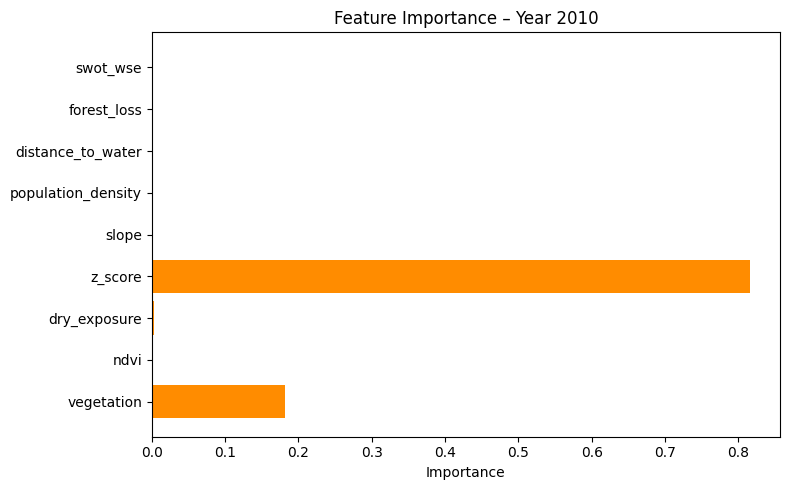

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import rasterio
from rasterio.transform import from_origin
import numpy as np

# -------------------------------
# 🔹 Step 1: Load GPKG for 2024
# -------------------------------
gpkg_path = "/content/Output_1/recovery_training_2010.gpkg"
gdf_2010 = gpd.read_file(gpkg_path)

# Standardize column names
gdf_2010.columns = [col.strip().lower() for col in gdf_2010.columns]
if 'veg' in gdf_2010.columns:
    gdf_2010.rename(columns={'veg': 'vegetation'}, inplace=True)

# Feature and target columns
features = [
    'vegetation', 'ndvi', 'dry_exposure', 'z_score', 'slope',
    'population_density', 'distance_to_water', 'forest_loss', 'swot_wse'
]
target = 'recovery_index'

# Drop rows with missing target only
gdf_2010 = gdf_2010.dropna(subset=[target])
X = gdf_2010[features]
y = gdf_2010[target]

print(f"✅ Model will be trained on {len(gdf_2010):,} samples for year 2010")

# -------------------------------
# 🔹 Step 2: Train Random Forest
# -------------------------------
model_2010 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_2010.fit(X, y)

# -------------------------------
# 🔹 Step 3: Predict Recovery Index
# -------------------------------
gdf_2010['predicted_recovery'] = model_2010.predict(X)

# -------------------------------
# 🔹 Step 4: Rasterize to GeoTIFF
# -------------------------------
resolution = 0.0003  # degree grid cell
bounds = gdf_2010.total_bounds  # [minx, miny, maxx, maxy]
width = int((bounds[2] - bounds[0]) / resolution)
height = int((bounds[3] - bounds[1]) / resolution)
transform = from_origin(bounds[0], bounds[3], resolution, resolution)

# Create empty raster
raster = np.full((height, width), np.nan, dtype=np.float32)

# Map points to raster grid
for _, row in gdf_2010.iterrows():
    x, y = row.geometry.x, row.geometry.y
    col = int((x - bounds[0]) / resolution)
    row_idx = int((bounds[3] - y) / resolution)
    if 0 <= row_idx < height and 0 <= col < width:
        raster[row_idx, col] = row['predicted_recovery']

# Save GeoTIFF
tiff_path = "/content/Output_1/recovery_map_2010.tif"
with rasterio.open(
    tiff_path, "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs=gdf_2010.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)

print(f"✅ GeoTIFF saved to: {tiff_path}")

# -------------------------------
# 🔹 Step 5: Plot Feature Importance
# -------------------------------
importances = model_2010.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(features, importances, color='darkorange')
plt.title('Feature Importance – Year 2010')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
import os
import rasterio
from rasterio.enums import Resampling
import geopandas as gpd
import pandas as pd
import numpy as np

def resample_to_match(source_path, reference_path):
    with rasterio.open(reference_path) as ref:
        ref_shape = (ref.height, ref.width)
    with rasterio.open(source_path) as src:
        data = src.read(
            out_shape=(1, ref_shape[0], ref_shape[1]),
            resampling=Resampling.nearest
        )[0]
    return data

# --- Paths ---
base_path = "/content/Output_1"
year = 2020
ref_path = os.path.join(base_path, f"recovery_index_{year}.tif")

pop_path = "/content/GHSL_Population_2015.tif"
distance_path = os.path.join(base_path, "normalized_distance_to_water_2020.tif")
forest_loss_path = os.path.join(base_path, "forest_loss_2020.tif")

print(f"\n🔍 Extracting features for {year}...")

try:
    features = {
        'year': np.full(resample_to_match(ref_path, ref_path).shape, year),
        'vegetation': resample_to_match(os.path.join(base_path, f"veg_reclass_{year}.tif"), ref_path),
        'ndvi': resample_to_match(os.path.join(base_path, f"ndvi_{year}.tif"), ref_path),
        'dry_exposure': resample_to_match(os.path.join(base_path, f"dry_exposure_{year}.tif"), ref_path),
        'z_score': resample_to_match(os.path.join(base_path, f"z_score_{year}.tif"), ref_path),
        'slope': resample_to_match(os.path.join(base_path, f"slope_{year}.tif"), ref_path),
        'population_density': resample_to_match(pop_path, ref_path),
        'distance_to_water': resample_to_match(distance_path, ref_path),
        'forest_loss': resample_to_match(forest_loss_path, ref_path),
        'swot_wse': np.full(resample_to_match(ref_path, ref_path).shape, np.nan)  # No SWOT data for 2020
    }

    with rasterio.open(ref_path) as ref_src:
        target = ref_src.read(1)
        target[target == ref_src.nodata] = np.nan
        features['recovery_index'] = target

        rows, cols = np.meshgrid(np.arange(ref_src.height), np.arange(ref_src.width), indexing='ij')
        xs, ys = rasterio.transform.xy(ref_src.transform, rows, cols)
        features['x'] = np.array(xs).flatten()
        features['y'] = np.array(ys).flatten()
        crs = ref_src.crs

    df = pd.DataFrame({k: v.flatten() for k, v in features.items()})
    print(f"📏 Total samples: {len(df)}")
    print(f"❗ Missing values per column:\n{df.isna().sum()[df.isna().sum() > 0]}")

    df = df.dropna(subset=['recovery_index'])
    print(f"✅ Valid training samples: {len(df)}")

    csv_path = os.path.join(base_path, f"recovery_training_{year}.csv")
    gpkg_path = os.path.join(base_path, f"recovery_training_{year}.gpkg")

    df.to_csv(csv_path, index=False)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs=crs)
    gdf.to_file(gpkg_path, driver="GPKG")

    print(f"💾 CSV saved: {csv_path}")
    print(f"🌍 GPKG saved: {gpkg_path}")

except Exception as e:
    print(f"❌ Error: {e}")


🔍 Extracting features for 2020...
📏 Total samples: 819312
❗ Missing values per column:
vegetation            734208
ndvi                  704990
dry_exposure          704478
population_density    689130
swot_wse              819312
recovery_index        734208
dtype: int64
✅ Valid training samples: 85104
💾 CSV saved: /content/Output_1/recovery_training_2020.csv
🌍 GPKG saved: /content/Output_1/recovery_training_2020.gpkg


✅ Model will be trained on 85,104 samples for year 2020
✅ GeoTIFF saved to: /content/Output_1/recovery_map_2020.tif


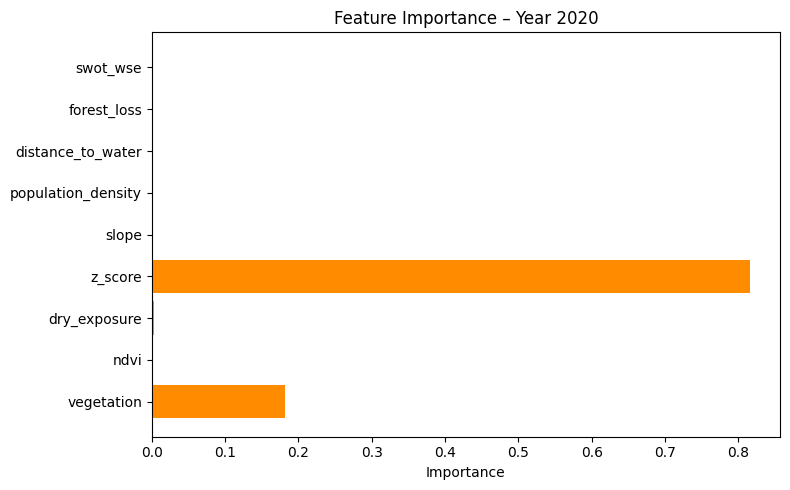

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import rasterio
from rasterio.transform import from_origin
import numpy as np

# -------------------------------
# 🔹 Step 1: Load GPKG for 2020
# -------------------------------
gpkg_path = "/content/Output_1/recovery_training_2020.gpkg"
gdf_2020 = gpd.read_file(gpkg_path)

# Standardize column names
gdf_2020.columns = [col.strip().lower() for col in gdf_2020.columns]
if 'veg' in gdf_2020.columns:
    gdf_2020.rename(columns={'veg': 'vegetation'}, inplace=True)

# Feature and target columns
features = [
    'vegetation', 'ndvi', 'dry_exposure', 'z_score', 'slope',
    'population_density', 'distance_to_water', 'forest_loss', 'swot_wse'
]
target = 'recovery_index'

# Drop rows with missing target only
gdf_2020 = gdf_2020.dropna(subset=[target])
X = gdf_2020[features]
y = gdf_2020[target]

print(f"✅ Model will be trained on {len(gdf_2020):,} samples for year 2020")

# -------------------------------
# 🔹 Step 2: Train Random Forest
# -------------------------------
model_2020 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_2020.fit(X, y)

# -------------------------------
# 🔹 Step 3: Predict Recovery Index
# -------------------------------
gdf_2020['predicted_recovery'] = model_2020.predict(X)

# -------------------------------
# 🔹 Step 4: Rasterize to GeoTIFF
# -------------------------------
resolution = 0.0003  # degree grid cell
bounds = gdf_2020.total_bounds  # [minx, miny, maxx, maxy]
width = int((bounds[2] - bounds[0]) / resolution)
height = int((bounds[3] - bounds[1]) / resolution)
transform = from_origin(bounds[0], bounds[3], resolution, resolution)

# Create empty raster
raster = np.full((height, width), np.nan, dtype=np.float32)

# Map points to raster grid
for _, row in gdf_2020.iterrows():
    x, y = row.geometry.x, row.geometry.y
    col = int((x - bounds[0]) / resolution)
    row_idx = int((bounds[3] - y) / resolution)
    if 0 <= row_idx < height and 0 <= col < width:
        raster[row_idx, col] = row['predicted_recovery']

# Save GeoTIFF
tiff_path = "/content/Output_1/recovery_map_2020.tif"
with rasterio.open(
    tiff_path, "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs=gdf_2020.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)

print(f"✅ GeoTIFF saved to: {tiff_path}")

# -------------------------------
# 🔹 Step 5: Plot Feature Importance
# -------------------------------
importances = model_2020.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(features, importances, color='darkorange')
plt.title('Feature Importance – Year 2020')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
import os
import rasterio
from rasterio.enums import Resampling
import geopandas as gpd
import pandas as pd
import numpy as np

def resample_to_match(source_path, reference_path):
    with rasterio.open(reference_path) as ref:
        ref_shape = (ref.height, ref.width)
    with rasterio.open(source_path) as src:
        data = src.read(
            out_shape=(1, ref_shape[0], ref_shape[1]),
            resampling=Resampling.nearest
        )[0]
    return data

# --- Paths ---
base_path = "/content/Output_1"
year = 2024
ref_path = os.path.join(base_path, f"recovery_index_{year}.tif")

pop_path = "/content/GHSL_Population_2015.tif"
distance_path = os.path.join(base_path, "normalized_distance_to_water_2024.tif")
forest_loss_path = os.path.join(base_path, "forest_loss_2024.tif")

print(f"\n🔍 Extracting features for {year}...")

try:
    features = {
        'year': np.full(resample_to_match(ref_path, ref_path).shape, year),
        'vegetation': resample_to_match(os.path.join(base_path, f"veg_reclass_{year}.tif"), ref_path),
        'ndvi': resample_to_match(os.path.join(base_path, f"ndvi_{year}.tif"), ref_path),
        'dry_exposure': resample_to_match(os.path.join(base_path, f"dry_exposure_{year}.tif"), ref_path),
        'z_score': resample_to_match(os.path.join(base_path, f"z_score_{year}.tif"), ref_path),
        'slope': resample_to_match(os.path.join(base_path, f"slope_{year}.tif"), ref_path),
        'population_density': resample_to_match(pop_path, ref_path),
        #'distance_to_water': resample_to_match(distance_path, ref_path),
        'forest_loss': resample_to_match(forest_loss_path, ref_path),
        'swot_wse': np.full(resample_to_match(ref_path, ref_path).shape, np.nan)  # No SWOT data for 2020
    }

    with rasterio.open(ref_path) as ref_src:
        target = ref_src.read(1)
        target[target == ref_src.nodata] = np.nan
        features['recovery_index'] = target

        rows, cols = np.meshgrid(np.arange(ref_src.height), np.arange(ref_src.width), indexing='ij')
        xs, ys = rasterio.transform.xy(ref_src.transform, rows, cols)
        features['x'] = np.array(xs).flatten()
        features['y'] = np.array(ys).flatten()
        crs = ref_src.crs

    df = pd.DataFrame({k: v.flatten() for k, v in features.items()})
    print(f"📏 Total samples: {len(df)}")
    print(f"❗ Missing values per column:\n{df.isna().sum()[df.isna().sum() > 0]}")

    df = df.dropna(subset=['recovery_index'])
    print(f"✅ Valid training samples: {len(df)}")

    csv_path = os.path.join(base_path, f"recovery_training_{year}.csv")
    gpkg_path = os.path.join(base_path, f"recovery_training_{year}.gpkg")

    df.to_csv(csv_path, index=False)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']), crs=crs)
    gdf.to_file(gpkg_path, driver="GPKG")

    print(f"💾 CSV saved: {csv_path}")
    print(f"🌍 GPKG saved: {gpkg_path}")

except Exception as e:
    print(f"❌ Error: {e}")


🔍 Extracting features for 2024...
📏 Total samples: 819312
❗ Missing values per column:
vegetation            734208
ndvi                  704990
dry_exposure          704478
population_density    689130
swot_wse              819312
recovery_index        734208
dtype: int64
✅ Valid training samples: 85104
💾 CSV saved: /content/Output_1/recovery_training_2024.csv
🌍 GPKG saved: /content/Output_1/recovery_training_2024.gpkg


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import rasterio
from rasterio.transform import from_origin
import numpy as np

# -------------------------------
# 🔹 Step 1: Load GPKG for 2024
# -------------------------------
gpkg_path = "/content/Output_1/recovery_training_2024.gpkg"
gdf_2024 = gpd.read_file(gpkg_path)

# Standardize column names
gdf_2024.columns = [col.strip().lower() for col in gdf_2024.columns]
if 'veg' in gdf_2024.columns:
    gdf_2024.rename(columns={'veg': 'vegetation'}, inplace=True)

# Feature and target columns
features = [
    'vegetation', 'ndvi', 'dry_exposure', 'z_score', 'slope',
    'population_density', 'distance_to_water', 'forest_loss', 'swot_wse'
]
target = 'recovery_index'

# Drop rows with missing target only
gdf_2024 = gdf_2024.dropna(subset=[target])
X = gdf_2024[features]
y = gdf_2024[target]

print(f"✅ Model will be trained on {len(gdf_2024):,} samples for year 2024")

# -------------------------------
# 🔹 Step 2: Train Random Forest
# -------------------------------
model_2024 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_2024.fit(X, y)

# -------------------------------
# 🔹 Step 3: Predict Recovery Index
# -------------------------------
gdf_2024['predicted_recovery'] = model_2024.predict(X)

# -------------------------------
# 🔹 Step 4: Rasterize to GeoTIFF
# -------------------------------
resolution = 0.0003  # degree grid cell
bounds = gdf_2024.total_bounds  # [minx, miny, maxx, maxy]
width = int((bounds[2] - bounds[0]) / resolution)
height = int((bounds[3] - bounds[1]) / resolution)
transform = from_origin(bounds[0], bounds[3], resolution, resolution)

# Create empty raster
raster = np.full((height, width), np.nan, dtype=np.float32)

# Map points to raster grid
for _, row in gdf_2024.iterrows():
    x, y = row.geometry.x, row.geometry.y
    col = int((x - bounds[0]) / resolution)
    row_idx = int((bounds[3] - y) / resolution)
    if 0 <= row_idx < height and 0 <= col < width:
        raster[row_idx, col] = row['predicted_recovery']

# Save GeoTIFF
tiff_path = "/content/Output_1/recovery_map_2024.tif"
with rasterio.open(
    tiff_path, "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=raster.dtype,
    crs=gdf_2024.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)

print(f"✅ GeoTIFF saved to: {tiff_path}")

# -------------------------------
# 🔹 Step 5: Plot Feature Importance
# -------------------------------
importances = model_2024.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(features, importances, color='darkorange')
plt.title('Feature Importance – Year 2024')
plt.xlabel("Importance")
plt.tight_layout()
plt.show()




KeyError: "['distance_to_water'] not in index"

In [ ]:
import os
import rasterio
from rasterio.enums import Resampling
import numpy as np

def resample_to_match(source, reference):
    data = source.read(
        out_shape=(1, reference.height, reference.width),
        resampling=Resampling.nearest
    )[0]
    return data

base_path = "/content/drive/MyDrive/Recovery/Output_1"

year_pairs = [
    (1990, 2000),
    (2000, 2010),
    (2010, 2020),
    (2020, 2024)
]

for year1, year2 in year_pairs:
    print(f"🔄 Processing change from {year1} to {year2}")

    path1 = os.path.join(base_path, f"recovery_map_{year1}.tif")
    path2 = os.path.join(base_path, f"recovery_map_{year2}.tif")
    out_path = os.path.join(base_path, f"change_{year1}_{year2}.tif")

    with rasterio.open(path1) as src1, rasterio.open(path2) as src2:
        # Read base (reference) raster
        rec1 = src1.read(1).astype("float32")
        rec1[rec1 == src1.nodata] = np.nan

        # Resample second raster to match base
        rec2 = resample_to_match(src2, src1).astype("float32")
        rec2[rec2 == src2.nodata] = np.nan

        # Compute difference
        change = rec2 - rec1
        change[np.isnan(rec1) | np.isnan(rec2)] = np.nan

        # Save output
        profile = src1.profile.copy()
        profile.update(dtype="float32", nodata=np.nan)

        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(change, 1)

        print(f"✅ Saved: {out_path}")


🔄 Processing change from 1990 to 2000
✅ Saved: /content/drive/MyDrive/Recovery/Output_1/change_1990_2000.tif
🔄 Processing change from 2000 to 2010
✅ Saved: /content/drive/MyDrive/Recovery/Output_1/change_2000_2010.tif
🔄 Processing change from 2010 to 2020
✅ Saved: /content/drive/MyDrive/Recovery/Output_1/change_2010_2020.tif
🔄 Processing change from 2020 to 2024
✅ Saved: /content/drive/MyDrive/Recovery/Output_1/change_2020_2024.tif
